In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from dateutil import parser
try:
    import Hawkes as hk
except:
    import Hawkes as hk
import requests
from datetime import datetime, timedelta, timezone
import pytz
import ast
import seaborn as sns
from tqdm import tqdm
import time
import warnings
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

warnings.filterwarnings("ignore")

c:\Users\hsee\OneDrive - LMR Partners\Documents\count process\.venv\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [79]:
HEADERS = {
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
}

TWEET_API_URL = {
    "elon" : "https://www.xtracker.io/api/users?stats=true&platform=X",
    "trump" : "https://www.xtracker.io/api/users?stats=true&platform=TRUTH_SOCIAL"
}
NAME = {
    "elon" : "Elon Musk",
    "trump" : "Donald Trump"
}
TIMEZONE_INFO = {"EDT": -4 * 3600, "EST": -5 * 3600}

def fetch_tweets(person, utc=True):
    try:
        csv_path = 'elonmusk.csv'

        with open(csv_path, mode='r', encoding='utf-8') as f:
            large_text = f.read()

        id = re.findall(r'(\d+),"[\s\S]+?","\w\w\w .+"\n', large_text)
        text = re.findall(r'\d+,"([\s\S]+?)","\w\w\w .+"\n', large_text)
        date = re.findall(r'\d+,"[\s\S]+?","(\w\w\w .+)"\n', large_text)

        df = pd.DataFrame([id, text, date]).T
        
        df.columns = ["id", "text", "date"]
        df = df.iloc[8000:]
        df['date'] = np.where(df['date'].str.contains("Jan|Feb|Mar|Apr|May|Jun"),
                              df['date'] + ' 2025',
                              df['date'] + " 2024")
        if utc:
            df.date = pd.to_datetime(df.date.apply(
                lambda x: parser.parse(x, tzinfos=TIMEZONE_INFO)), utc=True)
            df['dateint'] = df['date'].astype(int) // (60 * 10 ** 9)
        else:
            df.date = pd.to_datetime(df.date.apply(
                lambda x: parser.parse(x, tzinfos=TIMEZONE_INFO)), utc=True)

        return df
    except Exception as e:
        return pd.DataFrame()

In [80]:
df = fetch_tweets('elon', utc=True)
df

,id,text,date,dateint
8000,1875928891858244032,💯 https://t.co/otPKlOeTLP,2025-01-05 15:34:35+00:00,28934854
8001,1875931298143084755,For anyone doubting the severity and depravity...,2025-01-05 15:44:09+00:00,28934864
8002,1875931398881824801,https://t.co/4rQwcyw4Lk,2025-01-05 15:44:33+00:00,28934864
8003,1875931711248474433,https://t.co/mt1csIreQd,2025-01-05 15:45:47+00:00,28934865
8004,1875933025638441177,Imagine you are a father going to rescue your ...,2025-01-05 15:51:01+00:00,28934871
...,...,...,...,...
17172,1937570280978940198,RT @SawyerMerritt: NEWS: T-Mobile's satellite ...,2025-06-24 17:55:27+00:00,29179795
17173,1937570599305699635,RT @ramez: More EVs are now sold every year in...,2025-06-24 17:56:43+00:00,29179796
17174,1937572764816474565,RT @DimaZeniuk: Today's technology feels like ...,2025-06-24 18:05:20+00:00,29179805
17175,1937600690395987971,RT @BLKMDL3: Tesla Robotaxi perfectly handles ...,2025-06-24 19:56:18+00:00,29179916


In [81]:
fridays = (pd.date_range("2024-12-20", end = "2025-06-20", freq = "W") - pd.Timedelta(days = 2)).tz_localize(0) + pd.Timedelta(hours = 17)

In [169]:
fridays

DatetimeIndex(['2024-12-20 17:00:00+00:00', '2024-12-27 17:00:00+00:00',
               '2025-01-03 17:00:00+00:00', '2025-01-10 17:00:00+00:00',
               '2025-01-17 17:00:00+00:00', '2025-01-24 17:00:00+00:00',
               '2025-01-31 17:00:00+00:00', '2025-02-07 17:00:00+00:00',
               '2025-02-14 17:00:00+00:00', '2025-02-21 17:00:00+00:00',
               '2025-02-28 17:00:00+00:00', '2025-03-07 17:00:00+00:00',
               '2025-03-14 17:00:00+00:00', '2025-03-21 17:00:00+00:00',
               '2025-03-28 17:00:00+00:00', '2025-04-04 17:00:00+00:00',
               '2025-04-11 17:00:00+00:00', '2025-04-18 17:00:00+00:00',
               '2025-04-25 17:00:00+00:00', '2025-05-02 17:00:00+00:00',
               '2025-05-09 17:00:00+00:00', '2025-05-16 17:00:00+00:00',
               '2025-05-23 17:00:00+00:00', '2025-05-30 17:00:00+00:00',
               '2025-06-06 17:00:00+00:00', '2025-06-13 17:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=No

In [193]:
end_friday_int = fridays.astype(int)[3] // (60 * 10**9)
datetime.utcfromtimestamp(end_friday_int * 60)

datetime.datetime(2025, 1, 10, 17, 0)

In [82]:
def compute_intervals_for_index(i, df, fridays):
    """
    Compute prediction intervals for a single index i in the fridays array.
    Returns a list of interval dicts.
    """
    intervals = []
    # Convert timestamps to minutes
    train_start = fridays.astype(int)[i - 8] // (60 * 10**9)
    train_end   = fridays.astype(int)[i - 1] // (60 * 10**9)
    end_friday_int = fridays.astype(int)[i] // (60 * 10**9)

    # Range of moving end times at 1-minute steps
    moves = np.arange(train_end, end_friday_int, 60, dtype=float)
    
    # Precompute true count before loop
    # Note: this is the count from train_end up to each move time
    for move in moves:
        # Fit model on data from train_start to move
        train_data = df[(df.dateint >= train_start) & (df.dateint < move)].dateint.values.astype(float)
        model = hk.estimator().set_kernel('exp').set_baseline('const')
        model.fit(train_data, [train_start, move])

        # Compute counts
        tstamp = datetime.fromtimestamp(move * 60)
        true_count_till_now = len(df[(df.dateint >= train_end) & (df.dateint < move)])
        pred_samples = model.predict(end_friday_int, 1000)
        counts = [len(arr) + true_count_till_now for arr in pred_samples]

        intervals.append({
            't': tstamp,
            'pred': counts,
            'true_count': true_count_till_now
        })

    return intervals


def compute_all_intervals(df, fridays, n_jobs=-1, verbose=5):
    """
    Compute intervals in parallel for all valid indices in fridays.
    n_jobs: number of parallel jobs; -1 uses all CPUs.
    verbose: controls tqdm verbosity.
    """
    # Determine range of indices that have enough history
    valid_indices = list(range(8, len(fridays)))

    # Run in parallel
    with tqdm_joblib(desc="Simulation", total=len(valid_indices)) as progress_bar:
        results = Parallel(n_jobs=n_jobs, verbose=verbose)(
            delayed(compute_intervals_for_index)(i, df, fridays)
            for i in valid_indices
        )

    # Flatten list of lists
    all_intervals = [item for sublist in results for item in sublist]
    return all_intervals


In [83]:
intervals = compute_all_intervals(df, fridays, n_jobs=10, verbose=5)

Simulation: 100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


KeyboardInterrupt: 

In [ ]:
pred = pd.DataFrame(intervals)

In [ ]:
# Calculate mean, median, and 95% confidence intervals
pred['mean'] = pred['pred'].apply(np.mean)
pred['median'] = pred['pred'].apply(np.median)
pred['lower'] = pred['pred'].apply(lambda x: np.percentile(x, 2.5))
pred['upper'] = pred['pred'].apply(lambda x: np.percentile(x, 97.5))

plt.figure(figsize=(12, 6))
plt.plot(pred['t'], pred['mean'], label='Mean Prediction', color='blue')
plt.plot(pred['t'], pred['median'], label='Median Prediction', color='orange')
plt.plot(pred['t'], pred['true_count'], label='True count', color='orange')
plt.fill_between(pred['t'], pred['lower'], pred['upper'], color='gray', alpha=0.3, label='95% CI')
plt.xlabel('Time')
plt.ylabel('Predicted Count')
plt.title('Mean, Median, and 95% Confidence Interval of Predictions Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pred.to_parquet('elonmusk_8week.parquet', index=False)

In [2]:
import os
from glob import glob

folder_path = r'C:\Users\hsee\OneDrive - LMR Partners\Documents\count process\price_history'
parquet_files = glob(os.path.join(folder_path, '*.parquet'))
parquet_files

['C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_history\\Elon Musk # of tweets April 11-18.parquet',
 'C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_history\\Elon Musk # of tweets April 18-25.parquet',
 'C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_history\\Elon Musk # of tweets April 25- May 2.parquet',
 'C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_history\\Elon Musk # of tweets April 4-11 (Lower Brackets).parquet',
 'C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_history\\Elon Musk # of tweets April 4-11.parquet',
 'C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_history\\Elon Musk # of tweets Feb 14-21.parquet',
 'C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_history\\Elon Musk # of tweets Feb 21-28.parquet',
 'C:\\Users\\hsee\\OneDrive - LMR Partners\\Documents\\count process\\price_histor

In [3]:
pred = pd.read_parquet('elonmusk_4week.parquet')
pred['t'] = pd.to_datetime(pred['t'])

# attach the HK zone and hop to UTC
pred['t'] = (pred['t']
               .dt.tz_localize('Asia/Hong_Kong')  # stamp as local HK time
               .dt.tz_convert('UTC')
               .dt.tz_localize(None))             # convert to UTC

performance hint: .venv\Lib\site-packages\pyarrow\_azurefs.pyx:120:36: Exception check after calling 'GetResultValue[shared_ptr[CAzureFileSystem]]' will always require the GIL to be acquired. Declare 'GetResultValue[shared_ptr[CAzureFileSystem]]' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.


In [4]:
import re, math

def key_to_range(col_key: str) -> tuple[int, int | None]:
    """
    Convert one column name into (low, high).

    >>> key_to_range('will-elon-tweet-160174-times-june-1320_Yes')
    (160, 174)
    >>> key_to_range('will-elon-tweet-295-or-more-times-june-1320_Yes')
    (295, None)
    >>> key_to_range('will-elon-tweet-less-than-100-times-june-1320_Yes')
    (0, 99)
    """
    core = col_key.split("_")[0]       # drop the “_Yes / _No” suffix

    # 1) open-ended “or-more”
    m = re.search(r'(\d+)-or-more', core)
    if m:
        return int(m.group(1)), None

    # 2) “less-than-N”
    m = re.search(r'less-than-(\d+)', core)
    if m:
        return 0, int(m.group(1)) - 1

    # 3) regular 6-digit block  (e.g. 160174 → 160-174)
    m = re.search(r'(\d{6})times', core.replace('-', ''))
    if not m:
        raise ValueError(f"unrecognised pattern in {col_key!r}")
    num = m.group(1)
    return int(num[:3]), int(num[3:])

def point_to_range(row):
    predictions = pred[pred.t <=row['index']].iloc[-1].pred
    
    output = [[ranges , 0 ] for ranges in row.index if ranges != "index"]
    
    for i in predictions:
        for x in output:
            if x[0][0] <= i <= (x[0][1] if x[0][1] is not None else float('inf')):
                x[1] += 1 / 1000
    return output



In [5]:
import os

# Create output directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

for i, file in tqdm(enumerate(parquet_files)):
    try:
        tmp = pd.read_parquet(file)
        tmp = tmp[100:]
        tmp.fillna(0, inplace=True)
        normalised_data = tmp.div(tmp.sum(1), axis=0)

        ranges = [key_to_range(k) for k in normalised_data.columns]
        normalised_data.columns = ranges

        ser = normalised_data.reset_index().apply(lambda row: point_to_range(row), axis=1)
        df_plot = pd.DataFrame([dict(row) for row in ser])

        df_plot = df_plot.reindex(
            sorted(df_plot.columns, key=lambda rng: rng[0] if rng[0] is not None else -1),
            axis=1
        )
        df_plot.index = normalised_data.index
        normalised_data_trim = normalised_data[:-300]
        df_plot_trim = df_plot[:-300]

        plt.figure(figsize=(10, 6))
        (np.log(np.clip(df_plot_trim[normalised_data_trim.iloc[-1].idxmax()], 1e-5, 1-1e-5)) +
        np.log(np.clip(df_plot_trim[[col for col in df_plot_trim.columns if col != normalised_data_trim.iloc[-1].idxmax()]], 1e-5, 1-1e-5)).sum(1)).plot(label='Predicted')
        (np.log(np.clip(normalised_data_trim[normalised_data_trim.iloc[-1].idxmax()], 1e-5, 1-1e-5)) +
        np.log(np.clip(normalised_data_trim[[col for col in df_plot_trim.columns if col != normalised_data_trim.iloc[-1].idxmax()]], 1e-5, 1-1e-5)).sum(1)).plot(label='Actual')
        plt.legend()
        plt.title(os.path.basename(file))
        plt.tight_layout()
        plt.savefig(f'plots/{os.path.basename(file)}.png')
        plt.close()
    except:
        print(f"Error processing file {file}. Skipping.")
        continue

16it [02:49,  9.57s/it]

Error processing file C:\Users\hsee\OneDrive - LMR Partners\Documents\count process\price_history\Elon Musk # of tweets January 3-10 (Continued) .parquet. Skipping.
Error processing file C:\Users\hsee\OneDrive - LMR Partners\Documents\count process\price_history\Elon Musk # of tweets January 3-10.parquet. Skipping.


29it [04:55,  9.17s/it]

Error processing file C:\Users\hsee\OneDrive - LMR Partners\Documents\count process\price_history\Elon Musk # of tweets May 30 - June 6.parquet. Skipping.


31it [05:07,  9.90s/it]


In [13]:
import seaborn as sns

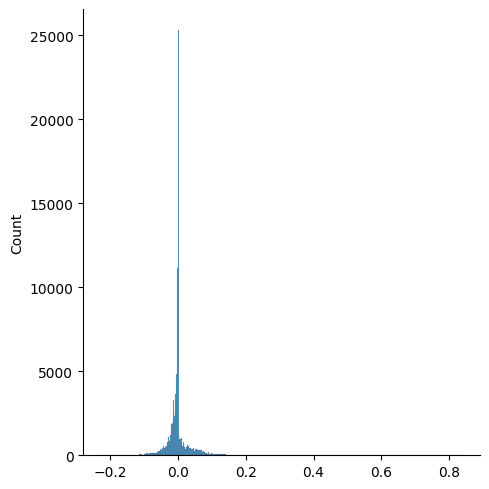

In [15]:
sns.displot((df_plot_trim - normalised_data_trim).values.flatten())

In [16]:
import requests

In [19]:
TRADE_API = {
    "elon" : "https://data-api.polymarket.com/trades?market=0x21668d96970d9915b53099eb8887afa735269d9b9a6be1990bf046bfce353722,0x5f00ee6dea46d14ed4072c9bfc218d181497d8719607e0e94769b9099a18994d,0x822355d49548602e82f77260f3779fe837d9b00ccd01f983aac44615862d9f93,0xef6ea4e68f2c30b2c6da3bae6163685b7a37f16dd7ba41f690f69fb7d58a844d,0x9fb2e2adf45b65d4afda76610b5765514219529ae300036d13aa6577be680508,0x5d072d5c80efad0ed4a29a14426ff2f1913e664c1135359a32018b7794f44b79,0xc9e0c5eda48b33180f47ad97c77db19a8d2707687af382d2e5639b9e391544cb,0x9eae3ac697455267a466d3528f906bd589e3150e85308cc03c2ee07646efc1e7,0x90cdae146f21b9d5809ff54ffaa318d2acb5b7e23aebd61f515a3854738bde0e,0x70c99edb32b0a74d8aae37a5530369d1f454231ccfbe08e93285de8feda67e4e,0x25cb58ab90fcd593928d08ef6291f687478f4ee9eab7b40f3f3122e659f6cb1c,0xa6467c33779e3a530938a0c0f5973927e5f3bf3fe4838854a47f12e77d183afe,0x76fa8b3759d1cb7a1f4269a76626b1f17acd23a51e91a0798044d127d2fdfff1,0xf7d25a080d942b0ceeb5f95c2e60f42d8cbf223025723e0bfac977ee9f002201", 
    "trump" : "https://data-api.polymarket.com/trades?market=0x9623c5216556a9b9f40cce7b285b50cca409a5ee2532f806846c9c4ab2ece2d2,0xe2efd43b1b655e537810774f658d25138c4001b03af03d718f672c3b8687378d,0x72594ec4f1686e8113a11f5812d7cc7198ea3af86e3bdced9e56d1593237edc7,0xb6a2213f6ac7eaea93e4ebf21995a161607c3eacfd66b2b4f4656e2715124e77,0xb73f4f309dd7107042f1cc9e032bf2123050aaa952a9e0e4616d3e80832147ec,0xe3b8391ba81e290597f7944701b4345a066dc02837251e0766f80489633f7e93,0x24bfd146dc3cf164839311f05ecdc8e7e61ff7f7b0b5d8f39607f656c8684fb4,0x69122741cd305bef99027fb3b0f474ad4afc71c60d56ea57b7a8eddfc34c8652,0x2a18c65fccc5cf697c25be750ae27b67fa61bcd879d8b93306fb2d997cc6152e"
}

    
TIMEZONE_INFO = {"EDT": -4 * 3600, "EST": -5 * 3600}
HEADERS = {
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
}

TWEET_API_URL = {
    "elon" : "https://www.xtracker.io/api/users?stats=true&platform=X",
    "trump" : "https://www.xtracker.io/api/users?stats=true&platform=TRUTH_SOCIAL"
}
NAME = {
    "elon" : "Elon Musk",
    "trump" : "Donald Trump"
}

def fetch_tweets(person, utc=True):
    try:
        trump_json = {
            'handle': 'realDonaldTrump',
            'platform': 'TRUTH_SOCIAL',
        }
        elon_json = {'handle': 'elonmusk'}

        if person == 'trump':
            response = requests.post('https://www.xtracker.io/api/download',
                                     headers=HEADERS,
                                     json= trump_json)
        elif person == 'elon':
            response = requests.post('https://www.xtracker.io/api/download',
                                     headers=HEADERS,
                                     json= elon_json)
        else:
            raise Exception("Unknown person")
            
        large_text = response.text

        id = re.findall(r'(\d+),"[\s\S]+?","\w\w\w .+"\n', large_text)
        text = re.findall(r'\d+,"([\s\S]+?)","\w\w\w .+"\n', large_text)
        date = re.findall(r'\d+,"[\s\S]+?","(\w\w\w .+)"\n', large_text)

        df = pd.DataFrame([id, text, date]).T
        
        df.columns = ["id", "text", "date"]
        df = df.iloc[8000:]
        df['date'] = np.where(df['date'].str.contains("Jan|Feb|Mar|Apr|May|Jun"),
                              df['date'] + ' 2025',
                              df['date'] + " 2024")
        if utc:
            df.date = pd.to_datetime(df.date.apply(
                lambda x: parser.parse(x, tzinfos=TIMEZONE_INFO)), utc=True)
            df['dateint'] = df['date'].astype(int) // (60 * 10 ** 9)
        else:
            df.date = pd.to_datetime(df.date.apply(
                lambda x: parser.parse(x, tzinfos=TIMEZONE_INFO)), utc=True)

        return df
    except Exception as e:
        print(f"Error fetching tweets for {person}: {e}")
        return pd.DataFrame()

In [20]:
fetch_tweets('elon')

Error fetching tweets for elon: Can only use .str accessor with string values!


""


In [28]:
data = requests.post('https://www.xtracker.io/api/download',
                                     headers=HEADERS,
                                     json= {'handle': 'elonmusk'}).json()
data

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [29]:
requests.post('https://www.xtracker.io/api/download',
                                     headers=HEADERS,
                                     json= {'handle': 'elonmusk'})

<Response [503]>